## Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
fashion_data = pd.read_csv('archive/Fashion Dataset v2.csv')
fashion_data.head()

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image
def display_images(df, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))
    for i, (idx, row) in enumerate(df.head(num_images).iterrows()):
        image_path = os.path.join('archive/images/', str(row['p_id']) + '.jpg')
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')
            table_data = [['Name', row['name']],
                          ['Brand', row['brand']],
                          ['Price', row['price']],
                          ['Rating', row['avg_rating']]]

            axes[i, 1].axis('off')
            mini_table = axes[i, 1].table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.2, 0.8])
            for cell in mini_table.get_celld().values():
                if cell.get_text().get_text() in ['Name', 'Brand', 'Price', 'Rating']:
                    cell.get_text().set_fontweight('bold')
                cell.get_text().set_fontsize(12)

            mini_table.auto_set_font_size(False)
            mini_table.set_fontsize(12)
            mini_table.scale(1.2, 1.2)
        else:
            print(f"Image not found for p_id: {row['p_id']}")

    plt.tight_layout()
    plt.show()


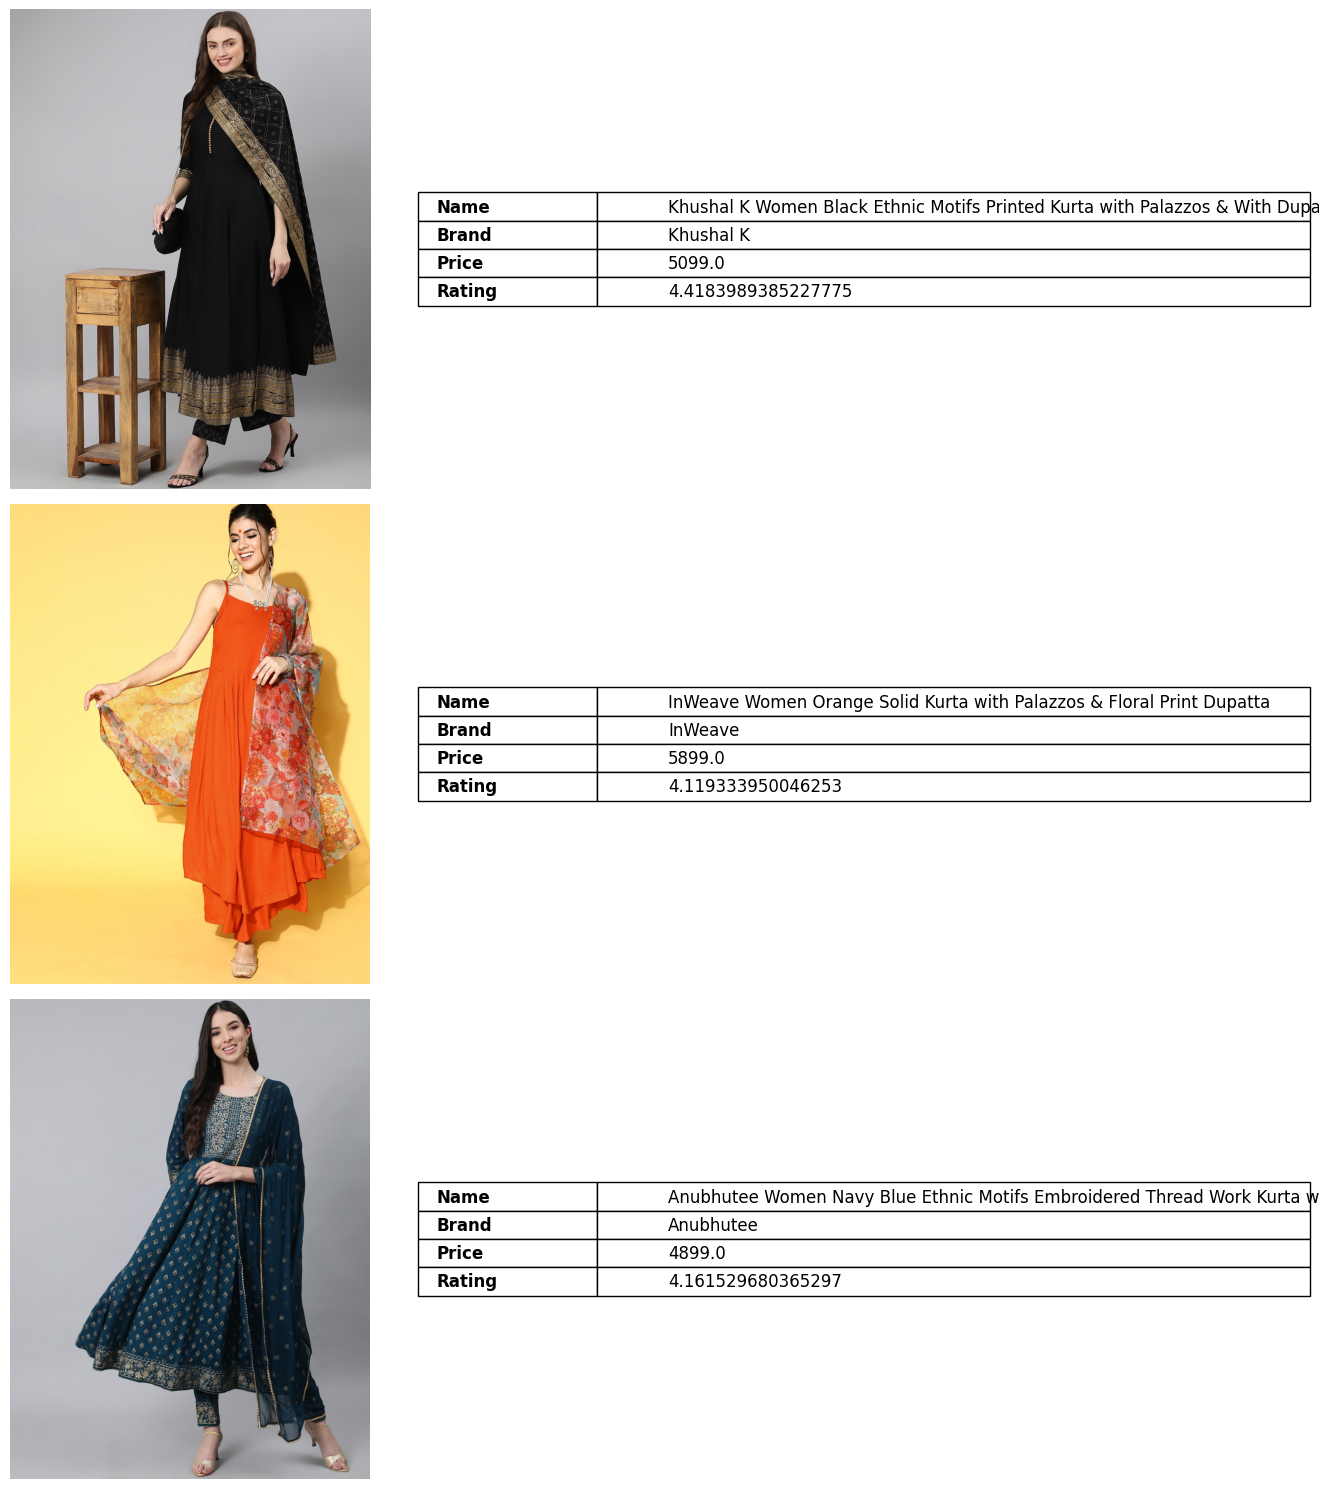

In [4]:
display_images(fashion_data, 3)

## Embedding Layer

**CREATING TEXT**

In [5]:
import re
def remove_html_tags(text):

    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [6]:
fashion_data['metadata'] = fashion_data.apply(
lambda x : {
    'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': remove_html_tags(x['description']),  # Description of the product
        'Product_attributes': x['p_attributes'] 
},axis = 1)

def extract_text(metadata):
    text_content = ""
    if "Description" in metadata and metadata["Description"]:
        text_content += metadata["Description"]
    if "name" in metadata:
        text_content += " " + metadata["name"] 
    if not text_content:
        text_content = "No description available."
    return text_content.strip()

documents = [extract_text(row['metadata']) for _,row in fashion_data.iterrows()]

In [7]:
import chromadb
from chromadb.db.base import UniqueConstraintError
from chromadb.utils import embedding_functions

api_key = "API_KEY"

em  = embedding_functions.GoogleGenerativeAiEmbeddingFunction(api_key=api_key)
client = chromadb.PersistentClient(path="db/")  # data stored in 'db' folder
# em = embedding_functions.SentenceTransformerEmbeddingFunction(model_name='sentence-transformers/all-MiniLM-L6-v2')

try:
    fashion_collection = client.create_collection(name='fashion_items', embedding_function=em)
except UniqueConstraintError:  # already exist collection
    fashion_collection = client.get_collection(name='fashion_items', embedding_function=em)


In [8]:
training = False #Make it True to train
if training:
    for idx, (p_id, metadata) in enumerate(zip(fashion_data['p_id'], fashion_data['metadata'])):
        print(f"Processing document with p_id={p_id} & {idx}")
        print(f"Document text: {documents[idx]}")
        try:
            if (len(documents[idx]) >= 500):
                continue
            
            fashion_collection.add(
                documents=[documents[idx]],  # Text content of the document
                ids=[str(p_id)],  # Unique identifier of the document
                metadatas=[metadata]  # Metadata associated with the document
            )
            
        except:
            print(f"Error adding document with p_id={p_id} & {idx}")

Processing document with p_id=17048614 & 0
Document text: Black printed Kurta with Palazzos with dupatta    Kurta design:     Ethnic motifs printed   Anarkali shape   Regular style   Mandarin collar,  three-quarter regular sleeves   Calf length with flared hem   Viscose rayon machine weave fabric     Palazzos design:     Printed Palazzos   Elasticated waistband   Slip-on closure  Dupatta Length 2.43 meters Width:&nbsp;88 cmThe model (height 5'8) is wearing a size S100% RayonMachine wash


I0000 00:00:1722701021.391971 1248942 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


Processing document with p_id=16524740 & 1
Document text: Orange solid Kurta with Palazzos with dupattaKurta design: SolidA-line shapeRegular styleSquare neck, sleeveless shoulder strapsCalf length with straight hemViscose rayon machine weave fabricPalazzos design: Solid PalazzosElasticated waistbandZip closureDupatta Design:Floral PrintedKurta Fabric: Viscose rayonBottom Fabric:&nbsp;Viscose rayonDupatta Fabric: OrganzaHand washThe model (height 5'8) is wearing a size S
Processing document with p_id=16331376 & 2
Document text: Navy blue embroidered Kurta with Trousers with dupatta    Kurta design:     Ethnic motifs embroidered   A-line shape   Regular style   Round neck,  three-quarter no sleeves   Thread work detail   Above knee length with flared hem   Viscose rayon machine weave fabric     Trousers design:     Printed Trousers   Elasticated waistband   Slip-on closure  Viscose rayonHand WashThe model (height 5'8) is wearing a size S
Processing document with p_id=14709966 & 3
Docume

### Cache Initialization

In [9]:
cache_collection_name = 'Fashion_Cache'
cache_collection = client.get_or_create_collection(name=cache_collection_name, embedding_function=em)

## Semantic Search

In [10]:
query = input("Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: ")
cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=5  # Number of results to retrieve
)
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

In [11]:
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    results = fashion_collection.query(
        query_texts=query,
        n_results=5
    )

    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        for i in range(len(val[0])):  # Iterate over the actual length of val
            Keys.append(str(key) + str(i))
            if len(val[0]) > i:  # Check if the current index exists in val
                Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[query],
        metadatas=dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in the main collection.")

    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)


elif cache_results['distances'][0][0] <= threshold and cache_results['ids']:
    cache_result_dict = cache_results['metadatas'][0][0]
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    
    print("Found in cache!")

    
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })
else:
    print("No valid results found in cache!")

Not found in cache. Found in the main collection.


In [12]:
results_df.sort_values('Distances')

Metadatas  \
0  {'Brand': 'Ishin', 'Colour': 'Navy Blue', 'Des...   
1  {'Brand': 'Pannkh', 'Colour': 'Maroon', 'Descr...   
2  {'Brand': 'Get Glamr', 'Colour': 'Green', 'Des...   
3  {'Brand': 'AURELIA', 'Colour': 'Cream', 'Descr...   
4  {'Brand': 'Masaba', 'Colour': 'Beige', 'Descri...   

                                           Documents  Distances       IDs  
0  This clothing set consists of top and skirtNav...   0.346533  11253928  
1  This clothing set consists of top and skirtMar...   0.369545  10806700  
2  This clothing set consists of top, trousers an...   0.373513  12073072  
3  This clothing set consists of top and skirt an...   0.381399  10190659  
4  This clothing set consists of top and skirtBei...   0.382377  16920506

In [13]:
list1 = results_df.sort_values('Distances')['IDs'].to_list()
list1 = [int(x) for x in list1]
result_data = fashion_data[fashion_data['p_id'].isin(list1)].copy()

result_data.drop(['metadata'], axis=1, inplace =True)
result_data['ratingCount'] = result_data['ratingCount'].fillna(0)
result_data['avg_rating'] = result_data['avg_rating'].fillna(0)
result_data

p_id                                               name  \
7201  16920506  Masaba Women Beige Floral Printed Drape Skirt ...   
7262  12073072  Get Glamr Women Green & Golden Foil Printed To...   
7290  11253928  Ishin Women Navy Blue & Golden Foil Printed To...   
7296  10190659  AURELIA Women Cream-Coloured & Pink Self Desig...   
7297  10806700  Pannkh Women Maroon & Golden Foil Print Top wi...   

                          products    price     colour      brand  \
7201                    Skirt, Top  22000.0      Beige     Masaba   
7262  Top, Trousers, Ethnic Jacket   2999.0      Green  Get Glamr   
7290                    Top, Skirt   4499.0  Navy Blue      Ishin   
7296      Top, Skirt, Ethnic Shrug   4999.0      Cream    AURELIA   
7297                    Top, Skirt   2799.0     Maroon     Pannkh   

                                                    img  ratingCount  \
7201  http://assets.myntassets.com/assets/images/169...          0.0   
7262  http://assets.myntassets.com/assets/images/120...        202.0   
7290  http://assets.myntassets.com/assets/images/112...          0.0   
7296  http://assets.myntassets.com/assets/images/101...         88.0   
7297  http://assets.myntassets.com/assets/images/108...          8.0   

      avg_rating                                        description  \
7201    0.000000  This clothing set consists of top and skirt<br...   
7262    4.282178  This clothing set consists of top, trousers an...   
7290    0.000000  This clothing set consists of top and skirt<br...   
7296    4.125000  This clothing set consists of top and skirt an...   
7297    3.500000  This clothing set consists of top and skirt<br...   

                                           p_attributes  
7201  {'Add-Ons': 'NA', 'Bottom Closure': 'Zip', 'Bo...  
7262  {'Add-Ons': 'NA', 'Bottom Closure': 'Slip-On',...  
7290  {'Add-Ons': 'NA', 'Bottom Closure': 'Drawstrin...  
7296  {'Add-Ons': 'NA', 'Bottom Closure': 'Slip-On',...  
7297  {'Add-Ons': 'NA', 'Bottom Closure': 'Slip-On',...

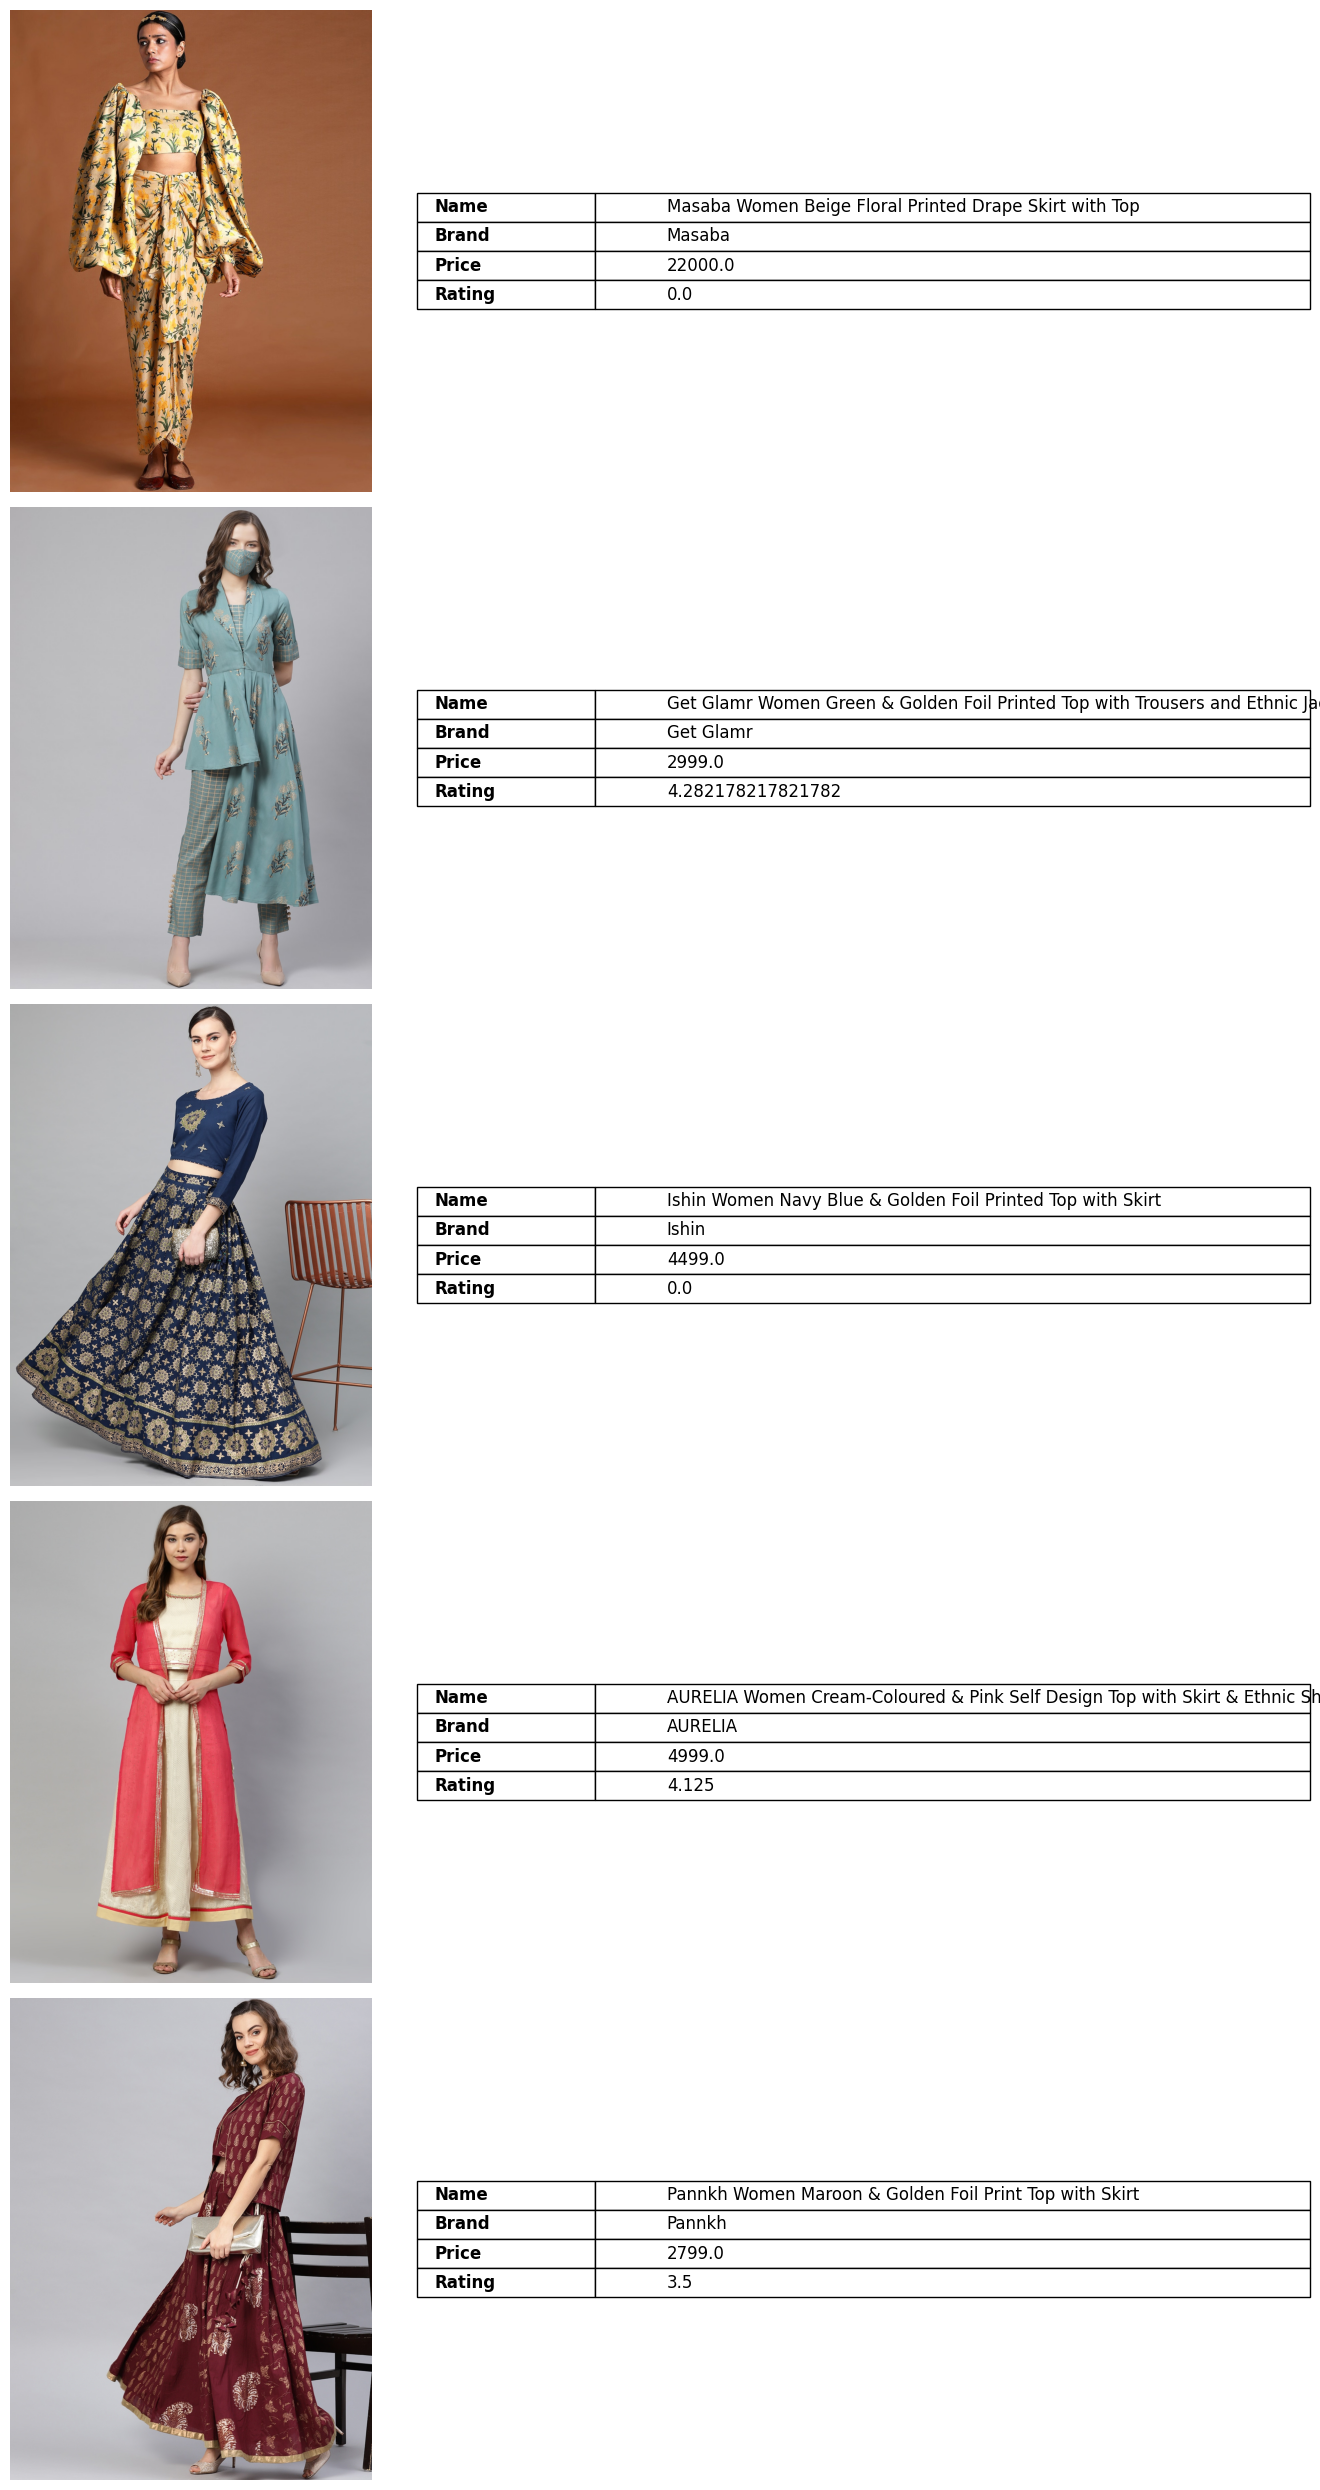

In [14]:
display_images(result_data)

In [16]:
results_df.sort_values('Distances')[["Metadatas","IDs"]]

Metadatas       IDs
0  {'Brand': 'Ishin', 'Colour': 'Navy Blue', 'Des...  11253928
1  {'Brand': 'Pannkh', 'Colour': 'Maroon', 'Descr...  10806700
2  {'Brand': 'Get Glamr', 'Colour': 'Green', 'Des...  12073072
3  {'Brand': 'AURELIA', 'Colour': 'Cream', 'Descr...  10190659
4  {'Brand': 'Masaba', 'Colour': 'Beige', 'Descri...  16920506

: 